In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from signals import *
from data.dataloader import DataLoader
from models.position_allocator import TestModel

### Load data

In [2]:
loader = DataLoader()
intraday_data = loader.load_raw_data(fillna=True)

Load data successfully!


100%|██████████| 17/17 [02:08<00:00,  7.54s/it]


In [3]:
print(sorted(intraday_data.keys()))

['ask_twap', 'bid_twap', 'close', 'high', 'hit_volume', 'hit_vwap', 'last_ask', 'last_bid', 'lift_volume', 'lift_vwap', 'low', 'num_hit', 'num_lift', 'num_trade', 'open', 'volume', 'vwap']


In [68]:
# import sys
# import importlib
# importlib.reload(sys.modules['signals'])
# importlib.reload(sys.modules['utils'])
# importlib.reload(sys.modules['models.backtest'])
# importlib.reload(sys.modules['models.base'])
# importlib.reload(sys.modules['models.position_allocator'])
# from utils import *
# from signals import *
# from models.backtest import PnLCalculator
# from models.base import Allocator
# from models.position_allocator import UnivariateModel, MultivariateModel, TestModel

# import warnings
# warnings.filterwarnings('ignore')

## Portfolio Allocation Model
### 1. Univariate Model

We start by building univariate model to investigate how individual reversal signal performs

In [74]:
performance, summary = {}, {}
notional = 1_000_000

def build_model(methods, name, func=None):
    model = TestModel(intraday_data)
    model.run(methods, func)
    p, s = model.evaluate()
    performance[name] = p
    summary[name] = s

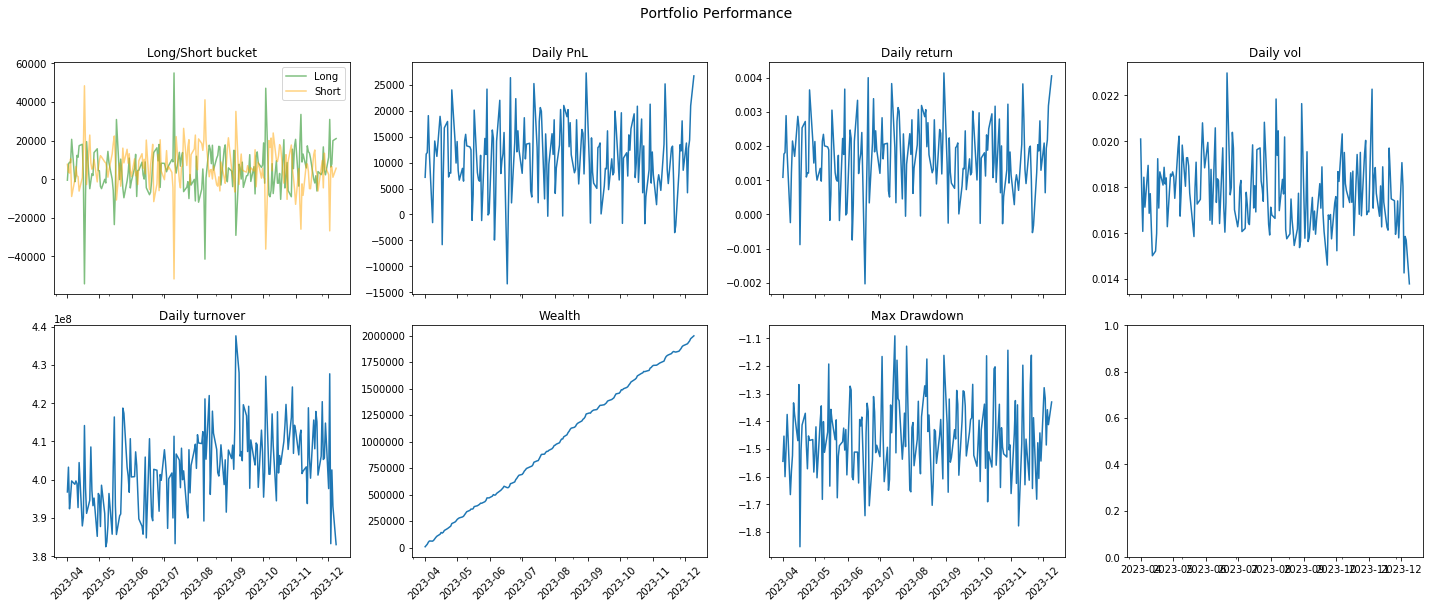

{'Sharpe': 1.5219041734281058, 'MDD': -1.8533937524809971, 'Max turnover': 437600000.0, 'Avg # position': 100.0}


In [75]:
# Bollinger band
methods = [('vwap', compute_bb, {'lookback': 5, 'rank': True, 'norm': True})]
build_model(methods, 'Bollinger')

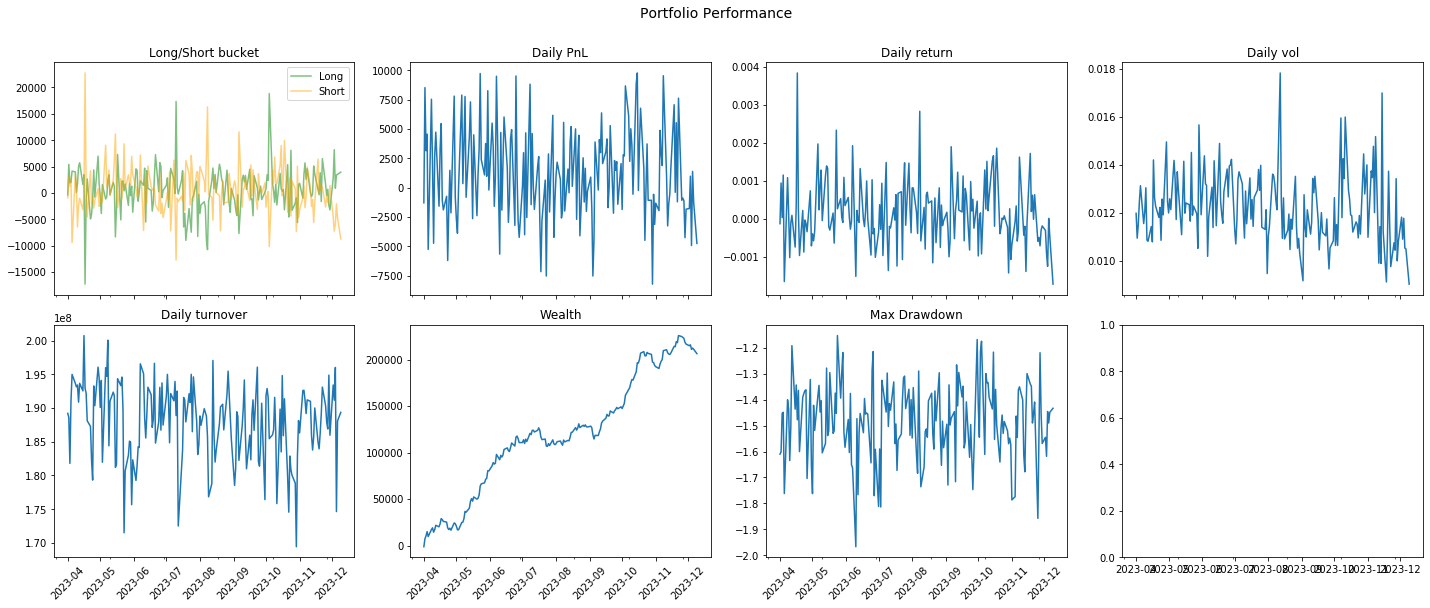

{'Sharpe': 0.18133433782345537, 'MDD': -1.9672415078292436, 'Max turnover': 200767469.59589303, 'Avg # position': 99.98359283442156}


In [76]:
# VWAP-based MACD
methods = [('vwap', compute_macd, {'fast_period': 5, 'slow_period': 30, 
                                    'norm_period': 10, 'signal_period': 5, 'smooth': True})]
build_model(methods, 'vwap_macd')

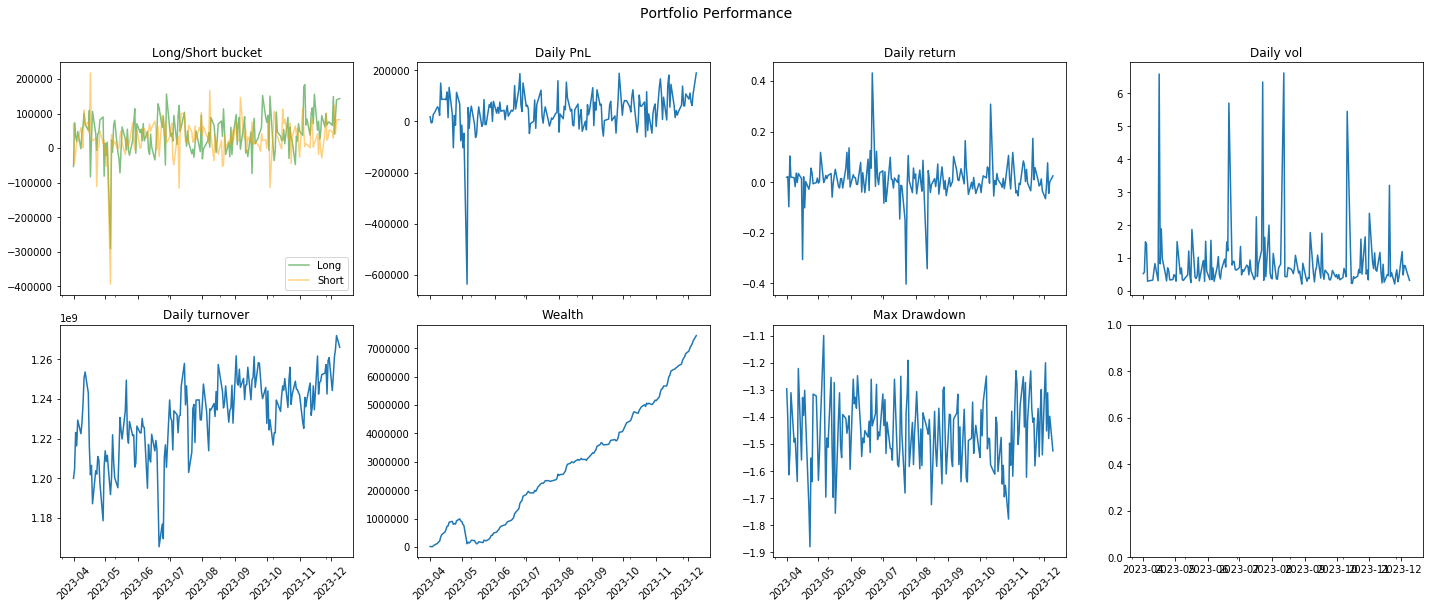

{'Sharpe': 0.2352432541543994, 'MDD': -1.879139519380884, 'Max turnover': 1271951510.097463, 'Avg # position': 46.47068474803282}


In [77]:
# Close-based, volume adjusted momentum
methods = [('close', compute_neg_ret, {'rank': False, 'scale_factor': intraday_data['volume']})]
build_model(methods, 'close_mom')

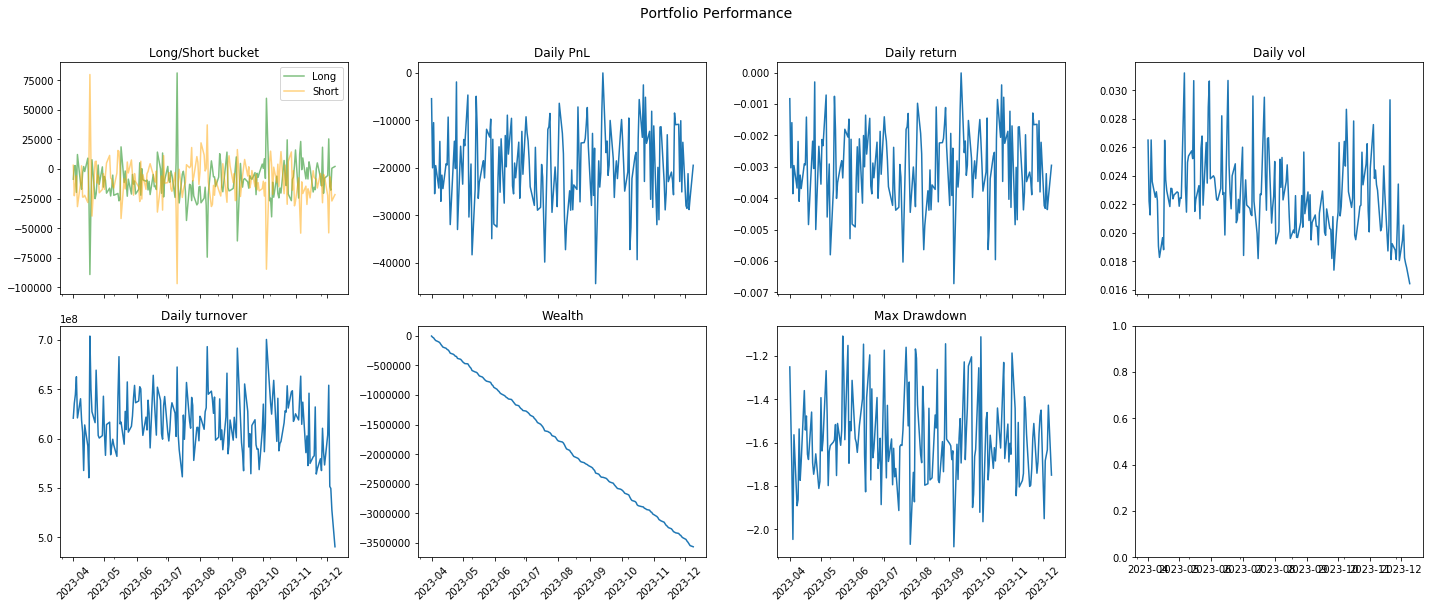

{'Sharpe': -2.127144135147804, 'MDD': -2.081114866188966, 'Max turnover': 704000000.0, 'Avg # position': 99.99832579943077}


In [78]:
# Close-based momentum, mapped to 0-1 interval (ranking)
# Preserving difference in signal scores is important for reversal signals
methods = [('close', compute_neg_ret, {'rank': True})]
build_model(methods, 'close_rank_mom')

In [80]:
# Helper function
def plot_summary(summary):
    fig, ax = plt.subplots(2, 4, figsize=(20,8), sharex=True)
    ax = ax.flatten()
    for method, df in summary.items():
        for i, c in enumerate(df.columns):
            ax[i].plot(df[c], label=method)
            ax[i].set_title(c)
            ax[i].tick_params(axis='x', labelrotation=45)
    plt.legend(bbox_to_anchor=(-2., -0.5), loc='lower center', ncol=len(summary))
    plt.xticks(rotation=45)
    plt.suptitle('Comparison of Portfolio Performance', y=.98)
    plt.tight_layout()
    plt.show()

def print_summary(summary):
    return pd.DataFrame(summary).transpose()

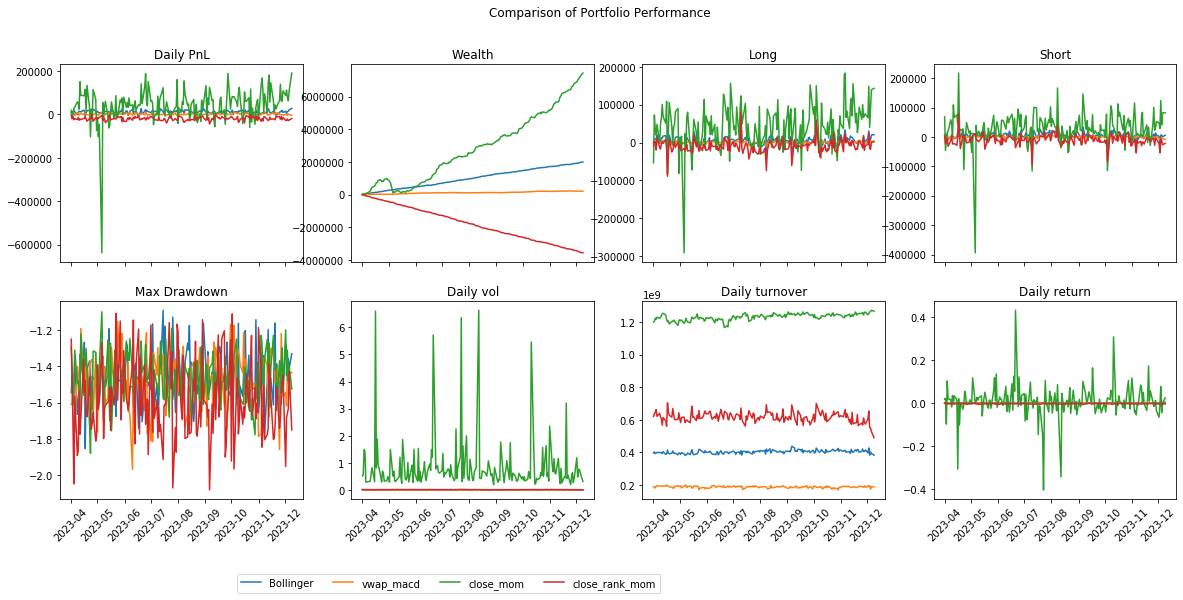

In [79]:
plot_summary(performance)

In [81]:
print_summary(summary)

,Sharpe,MDD,Max turnover,Avg # position
Bollinger,1.521904,-1.853394,4.376000e+08,100.000000
vwap_macd,0.181334,-1.967242,2.007675e+08,99.983593
close_mom,0.235243,-1.879140,1.271952e+09,46.470685
close_rank_mom,-2.127144,-2.081115,7.040000e+08,99.998326


Position assignment using Bollinger band appears to outperform other methods with superior Sharpe ratio, lowest max drawdown and considerably low max daily turnover. 

### 2. Multivariate Model

Given the performance of univariate model, we try to enhance the position assignment model by combining multiple signals in the weighting scheme.

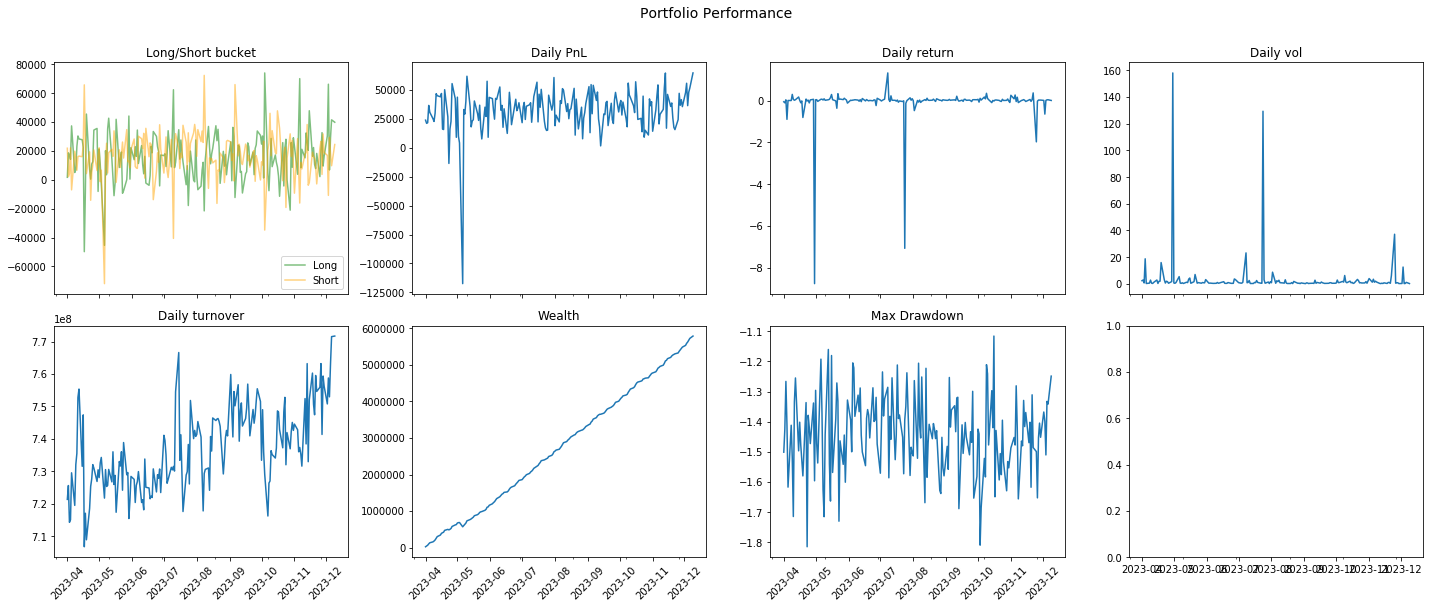

{'Sharpe': 0.41943132689413326, 'MDD': -1.8144818173071848, 'Max turnover': 771713930.8320494, 'Avg # position': 99.99832579943077}


In [82]:
# Combine Bollinger band and momentum
methods = [('close', compute_neg_ret, {'rank': False}),
           ('vwap', compute_bb, {'lookback': 5, 'rank': True, 'norm': True})]
build_model(methods, 'mom_bb_avg', avg)

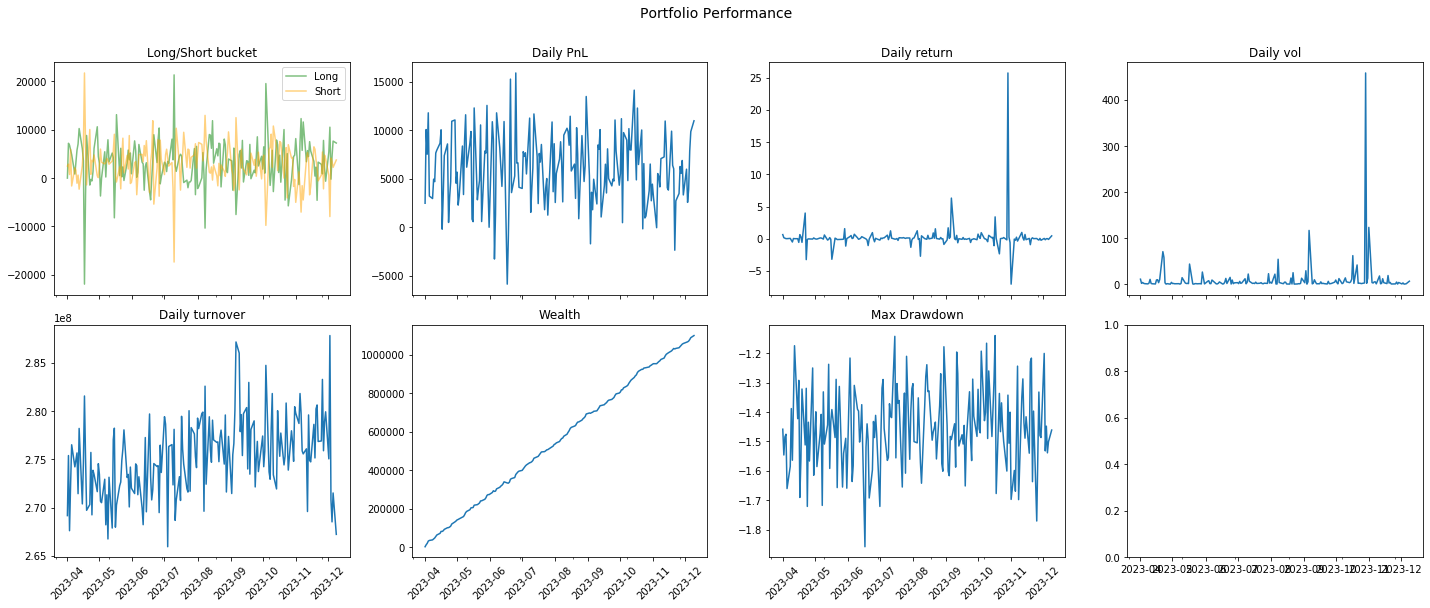

{'Sharpe': -0.014116213156929612, 'MDD': -1.858575440289458, 'Max turnover': 287843341.6327758, 'Avg # position': 99.98493219487695}


In [84]:
# Combine Bollinger band and MACD
methods = [('vwap', compute_bb, {'lookback': 5, 'rank': True, 'norm': True}),
           ('vwap', compute_macd, {'fast_period': 5, 'slow_period': 30, 
                                    'norm_period': 10, 'signal_period': 5, 'smooth': True})]
build_model(methods, 'macd_bb_avg', avg)

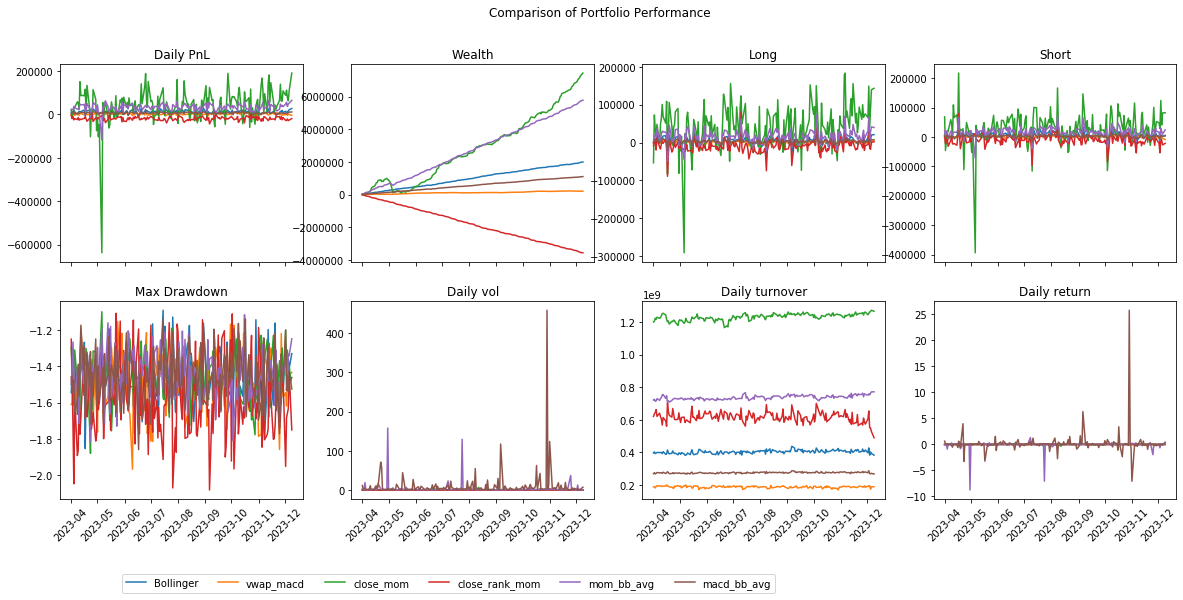

In [85]:
plot_summary(performance)

In [86]:
print_summary(summary)

,Sharpe,MDD,Max turnover,Avg # position
Bollinger,1.521904,-1.853394,4.376000e+08,100.000000
vwap_macd,0.181334,-1.967242,2.007675e+08,99.983593
close_mom,0.235243,-1.879140,1.271952e+09,46.470685
close_rank_mom,-2.127144,-2.081115,7.040000e+08,99.998326
mom_bb_avg,0.419431,-1.814482,7.717139e+08,99.998326
macd_bb_avg,-0.014116,-1.858575,2.878433e+08,99.984932


From the time series plots, we see that position assignment model based on solely **momentum (close-price) signals** results best wealth curve. However, it suffers from high daily turnover and large fluctuation in daily PnL (overall portfolio and long/short bucket), which leads to a comparatively lower Sharpe ratio.

Although univariate model based on **Bollinger band** achieves highest Sharpe ratio and low daily turnover, it is not able to generate attractive wealth curve as compared to other models.

A multivariate model, which combines **Momentum + Bollinger Band** strikes a good balance. Its corresponding portfolio generates second highest Sharpe ratio and a competitive wealth curve over time, while maintaining a much lower daily turnover than the univarate momentum model. We therefore propose this model as the ultimate target position assignment model.

### 